In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
import gc
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
from sklearn.preprocessing import label_binarize
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score  
from functools import reduce
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(0)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


0


In [2]:
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, hash_size: int, type_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.hashlayer = nn.Linear(1*32*32, hash_size)
        self.typelayer = nn.Linear(1*32*32, type_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x_hash = self.hashlayer(x)
        x_type = self.typelayer(x)
        return x_hash, x_type

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)
    
#https://github.com/marvis/pytorch-yolo2/blob/master/FocalLoss.py
#https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py  
class FocalLoss(nn.Module):
    #Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, out, y):
        y = y.view(-1,1)
        logpt = F.log_softmax(out,dim=1)#default ,dim=1
        logpt = logpt.gather(1,y)# dim=1, index=y, max
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=out.data.type():
                self.alpha = self.alpha.type_as(out.data)
            at = self.alpha.gather(0,y.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()
#https://github.com/qianjinhao/circle-loss
class CircleLoss(nn.Module):
    def __init__(self, scale=32, margin=0.25, similarity='cos', **kwargs):
        super(CircleLoss, self).__init__()
        self.scale = scale
        self.margin = margin
        self.similarity = similarity

    def forward(self, feats, labels):
        assert feats.size(0) == labels.size(0), \
            f"feats.size(0): {feats.size(0)} is not equal to labels.size(0): {labels.size(0)}"
        batch_size = feats.size(0)
        if self.similarity == 'dot':
            sim_mat = torch.matmul(feats, torch.t(feats))
        elif self.similarity == 'cos':
            feats = F.normalize(feats)
            sim_mat = feats.mm(feats.t())
        else:
            raise ValueError('This similarity is not implemented.')
        loss = list()
        for i in range(batch_size):
            pos_index = labels == labels[i]
            pos_index[i] = 0
            neg_index = labels != labels[i]
            pos_pair_ = sim_mat[i][pos_index]
            neg_pair_ = sim_mat[i][neg_index]

            alpha_p = torch.relu(-pos_pair_ + 1 + self.margin)
            alpha_n = torch.relu(neg_pair_ + self.margin)
            margin_p = 1 - self.margin
            margin_n = self.margin
            loss_p = torch.sum(torch.exp(-self.scale * alpha_p * (pos_pair_ - margin_p)))
            loss_n = torch.sum(torch.exp(self.scale * alpha_n * (neg_pair_ - margin_n)))
            loss.append(torch.log(1 + loss_p * loss_n))

        loss = sum(loss) / batch_size
        return loss    

#define loss function:pairwise loss            
class PairwiseLoss(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(PairwiseLoss, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss
    
#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])#[0:4555]
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    idx_2 = np.where( np.array(trY) == 2 ) #class 2
    idx_2 = list(idx_2[0])
    idx_sf.extend(idx_2)
    idx_3 = np.where( np.array(trY) == 3 ) #class 3
    idx_3 = list(idx_3[0])
    idx_sf.extend(idx_3)
    idx_4 = np.where( np.array(trY) == 4 ) #class 4
    idx_4 = list(idx_4[0])#[0:993]
    idx_sf.extend(idx_4)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    trQ_y, trP_y, trN_y = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        trQ_y.append(trY[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 2:
            idx_tmp = idx_2.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_2))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 3:
            idx_tmp = idx_3.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_3))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 4:
            idx_tmp = idx_4.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_4))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf), np.array(trQ_y), np.array(trP_y), np.array(trN_y)

In [3]:
#Read data with List storage Name:[name],I:[img],Y[type]
def TypetoNum(itype): #map the type into number.
    if itype =='AMD': return 1
    elif itype =='DR': return 2
    elif itype =='glaucoma': return 3
    elif itype =='myopia': return 4
    else: return 0 #norm
    
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
trainset = pd.read_csv("/data/fjsdata/fundus/iSee/iSee_multi_dataset/CBIR_iSee_train.csv" , sep=',')#load trainset
testset = pd.read_csv("/data/fjsdata/fundus/iSee/iSee_multi_dataset/CBIR_iSee_test.csv" , sep=',')#load testset
tstart = time.time()
#read train image with CV
trN, trI, trY = [],[],[]
norm = 6993
for iname, itype in np.array(trainset).tolist():
    if iname.endswith(".jpg"):
        try:
            image_dir = root_dir+'img_data_%s'%itype
            image_path = os.path.join(image_dir, iname)
            if itype == 'norm':
                if norm>0:
                    img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1920,1920,3)->(256,256,3)
                    trN.append(iname)
                    trI.append(img)
                    trY.append(TypetoNum(itype))
                    norm = norm - 1
            else:
                img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1920,1920,3)->(256,256,3)
                trN.append(iname)
                trI.append(img)
                trY.append(TypetoNum(itype))    
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trN),trainset.shape[0]))
        sys.stdout.flush()
print('The length of train set is %d'%len(trN))
#read test image with CV
teN, teI, teY = [],[],[]
norm = 777
for iname, itype in np.array(testset).tolist():
    if iname.endswith(".jpg"):
        try:
            image_dir = root_dir+'img_data_%s'%itype
            image_path = os.path.join(image_dir, iname)
            if itype == 'norm':
                if norm>0:
                    img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1920,1920,3)->(256,256,3)
                    teN.append(iname)
                    teI.append(img)
                    teY.append(TypetoNum(itype))
                    norm = norm - 1
            else:
                img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(1920,1920,3)->(256,256,3)
                teN.append(iname)
                teI.append(img)
                teY.append(TypetoNum(itype)) 
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teN),testset.shape[0]))
        sys.stdout.flush()
print('The length of test set is %d'%len(teN))
elapsed = time.time() - tstart    
print('Completed data handle in %d seconds' % int(elapsed))

9000 / 9000 The length of train set is 9000
1000 / 1000 The length of test set is 1000
Completed data handle in 795 seconds


In [6]:
#--------------------------------------------------------
#ATH-Triplet+CE
#--------------------------------------------------------
#sample  triplet labels
#trQ_sf, trP_sf, trN_sf, trQ_y, trP_y, trN_y = onlineGenImgPairs() 
assert (trQ_sf.shape==trP_sf.shape and trQ_sf.shape==trN_sf.shape)
assert (trQ_y.shape==trP_y.shape and trQ_y.shape==trN_y.shape)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trP_y))!=0,1,0))==0.0)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trN_y))!=0,1,0))==1.0)

#define model
model = ATHNet(hash_size=36, type_size=5).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
tl_loss  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
ce_loss  = nn.CrossEntropyLoss().cuda() #define cross-entropy loss

#train model
best_net, best_loss = None, float('inf')
batchSize = 10
plot_tripletloss = []
for epoch in range(50):#iteration
    losses, hash_losses, class_loss = [], [], []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_q_y = trQ_y[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_p_y = trP_y[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    train_n_y = trN_y[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Q_y_batch = torch.from_numpy(train_q_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_y_batch = torch.from_numpy(train_p_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_y_batch = torch.from_numpy(train_n_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        Q_hash, Q_type = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash, P_type = model(P_batch.permute(0, 3, 1, 2))
        N_hash, N_type = model(N_batch.permute(0, 3, 1, 2))
        #loss,#F.log_softmax+F.nll_loss
        hash_loss = tl_loss(Q_hash,P_hash,N_hash)
        type_loss = ce_loss(Q_type,Q_y_batch) + ce_loss(P_type,P_y_batch) + ce_loss(N_type,N_y_batch) 
        loss = hash_loss+type_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
        hash_losses.append(hash_loss.item())
        class_loss.append(type_loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    plot_tripletloss.append(np.mean(hash_losses))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
tl_loss=tl_loss.cpu()
ce_loss=ce_loss.cpu()
torch.cuda.empty_cache()

 900 / 900 : loss = 24.794512Eopch:     1 mean_loss = 20.643592
 900 / 900 : loss = 14.300351Eopch:     2 mean_loss = 19.329779
 900 / 900 : loss = 16.699152Eopch:     3 mean_loss = 18.330257
 900 / 900 : loss = 19.828735Eopch:     4 mean_loss = 16.497529
 900 / 900 : loss = 12.671606Eopch:     5 mean_loss = 15.294242
 900 / 900 : loss = 21.026741Eopch:     6 mean_loss = 13.669827
 900 / 900 : loss = 14.323267Eopch:     7 mean_loss = 12.439150
 900 / 900 : loss = 15.980244Eopch:     8 mean_loss = 11.492320
 900 / 900 : loss = 8.5032146Eopch:     9 mean_loss = 10.266158
 900 / 900 : loss = 10.470182Eopch:    10 mean_loss = 9.288874
 900 / 900 : loss = 7.4146175Eopch:    11 mean_loss = 8.387284
 900 / 900 : loss = 4.1651472Eopch:    12 mean_loss = 7.557140
 900 / 900 : loss = 7.6977146Eopch:    13 mean_loss = 6.756209
 900 / 900 : loss = 5.4493688Eopch:    14 mean_loss = 6.120780
 900 / 900 : loss = 10.763062Eopch:    15 mean_loss = 5.460130
 900 / 900 : loss = 7.0827071Eopch:    16 mean

In [7]:
print (plot_tripletloss)

[17.19490905019972, 16.138523411220973, 15.27953808678521, 13.567265672849285, 12.465564910808785, 10.974376009044548, 9.805674698294865, 8.898501250710753, 7.708006849521771, 6.789166804036746, 5.884611516456223, 5.090200038852377, 4.2893484655519325, 3.68937084286215, 3.107978306371305, 2.6667100233774788, 2.1364617234385674, 1.8807740409548084, 1.717733720787801, 1.362559432153228, 1.230248041275061, 1.1818840779179138, 0.9682118869324525, 0.9991373343186246, 0.8873830052923101, 0.8090240444874184, 0.7773097575642168, 0.6743753006329967, 0.6557964225392788, 0.6316299202882996, 0.5265758212298776, 0.5676938693592739, 0.551706732277655, 0.5991558107857903, 0.5347910418247597, 0.44688135346397756, 0.47425651371375555, 0.3340531005468155, 0.4555749459554338, 0.39682673548115416, 0.40412271675498534, 0.3948044294470714, 0.3693438702511291, 0.280456232022908, 0.3737329430774682, 0.3663472735116051, 0.32769884179074626, 0.3507867917358979, 0.30510521583879985, 0.3230860122521537]


In [8]:
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize 
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch,_ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teY_pred = []
teY_prob = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_type = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_type = F.log_softmax(x_type,dim=1) 
    teY_prob.extend(x_type.cpu().data.numpy().tolist())
    pred = x_type.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#performance of retrieval
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance of classification
#https://blog.csdn.net/hlang8160/article/details/78040311
#https://www.jianshu.com/p/7919ef304b19
#https://www.jianshu.com/p/c61ae11cc5f6
#https://www.cnblogs.com/yanshw/p/12691329.html
#TNR= TN / (FP + TN) ->low misdiagnosis rate->Specificity
#TPR=TP / (TP+ FN) -> low missed diagnosis rate->Sensitivity
#ROC: x axis = 1-TNR, y asis=TPR
#print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels) 
print (cm)
print ('Sensitivity(TPR) of Normal: %.6f'%float(cm[0][0]/np.sum(cm[0]))) 
print ('Sensitivity(TPR) of AMD: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity(TPR) of DR: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity(TPR) of Glaucoma: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity(TPR) of Myopia: %.6f'%float(cm[4][4]/np.sum(cm[4])))
#auc and roc
teY_one_hot = label_binarize(np.array(teY), np.arange(len(labels)))
auc_score = roc_auc_score(teY_one_hot, np.array(teY_prob), average='micro')#macro
print ('AUC (Area Under Curve) of Micro: %.6f'% auc_score)
fpr_tce, tpr_tce, thresholds = roc_curve(teY_one_hot.ravel(),np.array(teY_prob).ravel()) #for roc curve

 99 / 100  Completed buliding index in 22 seconds
mHR@10=0.749700, mAP@10=0.715217, mRR@10=0.934236
[[687  25  21  29  15]
 [ 52   4   7   2   7]
 [ 14   5   4   3   1]
 [ 38   2   4   0   1]
 [ 26  10   4  13  26]]
Sensitivity(TPR) of Normal: 0.884170
Sensitivity(TPR) of AMD: 0.055556
Sensitivity(TPR) of DR: 0.148148
Sensitivity(TPR) of Glaucoma: 0.000000
Sensitivity(TPR) of Myopia: 0.329114
AUC (Area Under Curve) of Micro: 0.897840


In [116]:
#figure 1 for problem introduction
image_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_DR/481483.jpg' #DR
Input_feature = []
Input_feature.append( cv2.resize(cv2.imread(image_dir).astype(np.float32), (256, 256)))
data = torch.from_numpy(np.array(Input_feature)).type(torch.FloatTensor).cuda()
Output_feature,logit = best_net(data.permute(0, 3, 1, 2))#forword
Output_feature=np.array(Output_feature.cpu().data.numpy().tolist())
map_item_score = {}
for j, trVal in enumerate(trF):
    map_item_score[j] = pdist(np.vstack([Output_feature[0],trVal]),'cosine')#hamming
ranklist = heapq.nsmallest(20, map_item_score, key=map_item_score.get)
for j in ranklist:
    print ('%s:%d-Distance:%.6f'%(trN[j],trY[j],map_item_score[j]))

481483.jpg:2-Distance:0.021004
496278.jpg:0-Distance:0.281160
488091.jpg:0-Distance:0.305985
488939.jpg:1-Distance:0.318543
481590.jpg:0-Distance:0.321325
484703.jpg:0-Distance:0.322712
92659.jpg:1-Distance:0.335201
908668.jpg:0-Distance:0.340074
910369.jpg:0-Distance:0.343832
486933.jpg:0-Distance:0.344289
488225.jpg:0-Distance:0.348042
98815.jpg:0-Distance:0.353763
909999.jpg:0-Distance:0.354402
82791.jpg:0-Distance:0.355593
99384.jpg:4-Distance:0.356089
98272.jpg:1-Distance:0.356324
89977.jpg:0-Distance:0.356890
496065.jpg:0-Distance:0.359909
488388.jpg:0-Distance:0.363795
913078.jpg:0-Distance:0.365187


In [112]:
#figure 1 for problem introduction
for i in range(len(teY)):
    if teY[i]==2 :#DR
    #if teN[i] in ['28901_right','19414_right']: 
        itype = teY[i]
        teVal = teF[i]
        image_path = os.path.join(root_dir, teN[i])
        map_item_score = {}
        for j, trVal in enumerate(trF):
            map_item_score[j] = pdist(np.vstack([teVal,trVal]),'cosine')#hamming
        ranklist = heapq.nsmallest(5, map_item_score, key=map_item_score.get)
        for j in ranklist:
            if trY[j]==2:
                print ('%s:%d-%s:%d-Distance:%.6f'%(teN[i],teY[i],trN[j],trY[j],map_item_score[j]))

495656.jpg:2-481483.jpg:2-Distance:0.290702


In [42]:
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = 1,1,32,32#feature_conv.shape
    
    output_cam = []
    for idx in class_idx:
        #cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
        cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
#last conv layer followed with one channel by last fully connected layer
final_conv = 'sa' 
best_net._modules.get(final_conv).register_forward_hook(hook_feature)
#get weights parameters
params = list(best_net.parameters())
#get the last and second last weights, like [classes, hiden nodes]
weight_softmax = np.squeeze(params[-2].data.cpu().numpy()) 
# define class type
classes = {0:'Norm', 1: 'AMD', 2: 'DR', 3:'Glaucoma', 4:'Myopia', }
#read image
root='/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_DR/100217.jpg'
img = []
img.append( cv2.resize(cv2.imread(root).astype(np.float32), (256, 256)))#(256, 256) is the model input size
data = torch.from_numpy(np.array(img)).type(torch.FloatTensor).cuda()
_,logit = best_net(data.permute(0, 3, 1, 2))#forword
h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
probs, idx = h_x.sort(0, True) #probabilities of classes

# output: the prediction
for i in range(0, len(classes)):
    line = '{:.3f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
#get the class activation maps
print (features_blobs[-1].shape)
feature_layer = features_blobs[-1].squeeze()[0]
feature_layer = cv2.resize(feature_layer, (32, 32))
CAMs = returnCAM(feature_layer, weight_softmax, [idx[0].item()])

# render the CAM and show
print('output CAM.jpg for the top1 prediction: %s' % classes[idx[0].item()])
img = cv2.imread(root)
height, width, _ = img.shape
CAM = cv2.resize(CAMs[0], (width, height))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
#result = heatmap * 0.3 + img * 0.5
result = heatmap 
cv2.imwrite('iSee_cam.jpg', result)

0.841 -> DR
0.072 -> Norm
0.067 -> Glaucoma
0.017 -> AMD
0.002 -> Myopia
(1, 1, 128, 128)
output CAM.jpg for the top1 prediction: DR


True

In [41]:
print (features_blobs[0].shape)
feature_layer = features_blobs[0].squeeze()
print (feature_layer.shape)
#feature_layer = np.mean(feature_layer, axis=0)
feature_layer = np.max(feature_layer, axis=0)
print (feature_layer.shape)
feature_layer = cv2.resize(feature_layer, (32, 32))
CAMs = returnCAM(feature_layer, weight_softmax, [idx[0].item()])

# render the CAM and show
print('output CAM.jpg for the top1 prediction: %s' % classes[idx[0].item()])
img = cv2.imread(root)
height, width, _ = img.shape
CAM = cv2.resize(CAMs[0], (width, height))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
#result = heatmap * 0.3 + img * 0.5
result = heatmap 
cv2.imwrite('iSee_cam.jpg', result)

(1, 16, 128, 128)
(16, 128, 128)
(128, 128)
output CAM.jpg for the top1 prediction: DR


True

In [47]:
#define model
model = ATHNet(hash_size=36, type_size=5).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
tl_loss  = TripletLoss(margin=0.5).cuda() #define TripletLoss 

#train model
best_net, best_loss = None, float('inf')
batchSize = 10
pl_t_i = []
for epoch in range(50):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        Q_hash, _ = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash, _ = model(P_batch.permute(0, 3, 1, 2))
        N_hash, _ = model(N_batch.permute(0, 3, 1, 2))
        #loss
        loss = tl_loss(Q_hash,P_hash,N_hash)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    pl_t_i.append(np.mean(losses))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
tl_loss=tl_loss.cpu()
ce_loss=ce_loss.cpu()
torch.cuda.empty_cache()

#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize 
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch,_ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teY_pred = []
teY_prob = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_type = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_type = F.log_softmax(x_type,dim=1) 
    teY_prob.extend(x_type.cpu().data.numpy().tolist())
    pred = x_type.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#performance of retrieval
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance of classification
#https://blog.csdn.net/hlang8160/article/details/78040311
#https://www.jianshu.com/p/7919ef304b19
#https://www.jianshu.com/p/c61ae11cc5f6
#https://www.cnblogs.com/yanshw/p/12691329.html
#TNR= TN / (FP + TN) ->low misdiagnosis rate->Specificity
#TPR=TP / (TP+ FN) -> low missed diagnosis rate->Sensitivity
#ROC: x axis = 1-TNR, y asis=TPR
#print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels) 
print (cm)
print ('Sensitivity(TPR) of Normal: %.6f'%float(cm[0][0]/np.sum(cm[0]))) 
print ('Sensitivity(TPR) of AMD: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity(TPR) of DR: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity(TPR) of Glaucoma: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity(TPR) of Myopia: %.6f'%float(cm[4][4]/np.sum(cm[4])))
#auc and roc
teY_one_hot = label_binarize(np.array(teY), np.arange(len(labels)))
auc_score = roc_auc_score(teY_one_hot, np.array(teY_prob), average='micro')#macro
print ('AUC (Area Under Curve) of Micro: %.6f'% auc_score)
fpr_tl, tpr_tl, thresholds = roc_curve(teY_one_hot.ravel(),np.array(teY_prob).ravel()) #for roc curve

 900 / 900 : loss = 17.614923Eopch:     1 mean_loss = 17.269549
 900 / 900 : loss = 15.560282Eopch:     2 mean_loss = 16.117119
 900 / 900 : loss = 19.702757Eopch:     3 mean_loss = 15.425354
 900 / 900 : loss = 7.6883012Eopch:     4 mean_loss = 14.387825
 900 / 900 : loss = 10.221549Eopch:     5 mean_loss = 13.455571
 900 / 900 : loss = 12.598732Eopch:     6 mean_loss = 12.175616
 900 / 900 : loss = 7.2787132Eopch:     7 mean_loss = 10.908250
 900 / 900 : loss = 19.430489Eopch:     8 mean_loss = 9.592487
 900 / 900 : loss = 0.7529739Eopch:     9 mean_loss = 8.074116
 900 / 900 : loss = 4.8095846Eopch:    10 mean_loss = 6.752805
 900 / 900 : loss = 3.0550255Eopch:    11 mean_loss = 5.895860
 900 / 900 : loss = 2.9965866Eopch:    12 mean_loss = 5.071240
 900 / 900 : loss = 6.6479396Eopch:    13 mean_loss = 4.504203
 900 / 900 : loss = 0.1788295Eopch:    14 mean_loss = 3.790285
 900 / 900 : loss = 14.437225Eopch:    15 mean_loss = 3.255619
 900 / 900 : loss = 0.0696288Eopch:    16 mean_l

In [52]:
#Generate image pairs for model
def onlineGenImgPairs():
    if (len(trY) % 2) == 0: spls = len(trY)
    else:  spls = len(trY)-1
    idx_sf = random.sample(range(0, spls),spls)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf

#define model
model = ATHNet(hash_size=36, type_size=5).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
criterion  = PairwiseLoss(margin=0.5).cuda() #define PairwiseLoss 
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(50):#iteration
    trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    losses = []
    num_batches = len(trY_sf) // batchSize 
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch,_ = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch,_ = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
tl_loss=tl_loss.cpu()
ce_loss=ce_loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize 
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch,_ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teY_pred = []
teY_prob = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_type = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_type = F.log_softmax(x_type,dim=1) 
    teY_prob.extend(x_type.cpu().data.numpy().tolist())
    pred = x_type.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#performance of retrieval
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance of classification
#https://blog.csdn.net/hlang8160/article/details/78040311
#https://www.jianshu.com/p/7919ef304b19
#https://www.jianshu.com/p/c61ae11cc5f6
#https://www.cnblogs.com/yanshw/p/12691329.html
#TNR= TN / (FP + TN) ->low misdiagnosis rate->Specificity
#TPR=TP / (TP+ FN) -> low missed diagnosis rate->Sensitivity
#ROC: x axis = 1-TNR, y asis=TPR
#print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels) 
print (cm)
print ('Sensitivity(TPR) of Normal: %.6f'%float(cm[0][0]/np.sum(cm[0]))) 
print ('Sensitivity(TPR) of AMD: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity(TPR) of DR: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity(TPR) of Glaucoma: %.6f'%float(cm[3][3]/np.sum(cm[3])))
print ('Sensitivity(TPR) of Myopia: %.6f'%float(cm[4][4]/np.sum(cm[4])))
#auc and roc
teY_one_hot = label_binarize(np.array(teY), np.arange(len(labels)))
auc_score = roc_auc_score(teY_one_hot, np.array(teY_prob), average='micro')#macro
print ('AUC (Area Under Curve) of Micro: %.6f'% auc_score)
fpr_pl, tpr_pl, thresholds = roc_curve(teY_one_hot.ravel(),np.array(teY_prob).ravel()) #for roc curve

 450 / 450 : loss = 1.804384Eopch:     1 mean_loss = 3.437861
 450 / 450 : loss = 2.701309Eopch:     2 mean_loss = 3.499912
 450 / 450 : loss = 1.801613Eopch:     3 mean_loss = 3.469247
 450 / 450 : loss = 3.600728Eopch:     4 mean_loss = 3.476900
 450 / 450 : loss = 4.500449Eopch:     5 mean_loss = 3.434739
 450 / 450 : loss = 4.500545Eopch:     6 mean_loss = 3.430594
 450 / 450 : loss = 4.500203Eopch:     7 mean_loss = 3.406621
 450 / 450 : loss = 4.500449Eopch:     8 mean_loss = 3.440555
 450 / 450 : loss = 5.400171Eopch:     9 mean_loss = 3.372390
 450 / 450 : loss = 1.800466Eopch:    10 mean_loss = 3.416363
 450 / 450 : loss = 2.700316Eopch:    11 mean_loss = 3.470363
 450 / 450 : loss = 5.400331Eopch:    12 mean_loss = 3.434344
 450 / 450 : loss = 4.500446Eopch:    13 mean_loss = 3.420465
 450 / 450 : loss = 3.600176Eopch:    14 mean_loss = 3.484007
 450 / 450 : loss = 5.400224Eopch:    15 mean_loss = 3.414373
 450 / 450 : loss = 2.700342Eopch:    16 mean_loss = 3.486264
 450 / 4

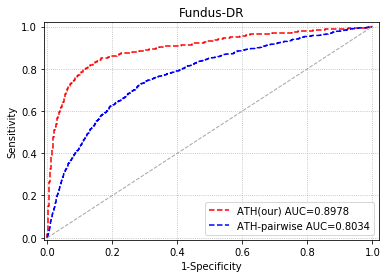

In [54]:
plt.plot(fpr_tce, tpr_tce, c = 'r', ls = '--', label = u'ATH(our) AUC=%.4f' % 0.8978)
plt.plot(fpr_tl, tpr_tl, c = 'b', ls = '--', label = u'ATH-pairwise AUC=%.4f' % 0.8034)
#plt.plot(fpr_pl, tpr_pl, c = 'b', ls = '--', label = u'ATH-pairwise AUC=%.4f' % 0.7734)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid(b=True, ls=':')
plt.legend(loc='lower right')
plt.title('Fundus-DR')
plt.show()

In [ ]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','s','*','+']
    label = ['AMD','DR','glaucoma','myopia','normal']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=label[i])
    plt.axis('off')
    plt.legend(loc='lower left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=5
#idx= random.sample(np.where(np.array(teY)==0)[0].tolist(),100)
idx= np.where(np.array(teY)==0)[0].tolist()
X0= np.array(teF)[idx]
y0= np.array(teY)[idx]

idx= np.where(np.array(teY)==1)[0].tolist()
X1= np.array(teF)[idx]
y1= np.array(teY)[idx]

idx= np.where(np.array(teY)==2)[0].tolist()
X2= np.array(teF)[idx]
y2= np.array(teY)[idx]

idx= np.where(np.array(teY)==3)[0].tolist()
X3= np.array(teF)[idx]
y3= np.array(teY)[idx]

idx= np.where(np.array(teY)==4)[0].tolist()
X4= np.array(teF)[idx]
y4= np.array(teY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
y = np.append(y,y3)
y = np.append(y,y4)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
X = np.vstack((X,X3))
X = np.vstack((X,X4))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)